In [1]:
import sys
sys.path.append('../.')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

**Load data**

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

dataset = 'red_wine'
X = pd.read_csv('data/winequality_red.csv', sep=';')
ind = list(range(len(X.columns)))
ind = [x for x in ind if x != X.columns.get_loc("quality")]
col_list = X.columns[ind]
ct = ColumnTransformer([('scaler', StandardScaler(), col_list)], remainder='passthrough')

X_ = ct.fit_transform(X)
X = pd.DataFrame(X_, index=X.index, columns=X.columns)

X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5.0
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,5.0
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,5.0
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,6.0
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5.0


**Fit model**

In [3]:
from sklearn.model_selection import train_test_split
from GoggleModel import GoggleModel

In [4]:
X_train, X_test = train_test_split(X, random_state=0, test_size=0.2, shuffle=True)

gen = GoggleModel(
    ds_name=dataset,
    input_dim=X_train.shape[1],
    encoder_dim=64,
    encoder_l=2,
    het_encoding=True,
    decoder_dim=64,
    decoder_l=2,
    threshold=0.1,
    het_decoder=False,
    graph_prior=None,
    prior_mask=None,
    device='cuda',
    beta=0.1,
    seed=0
)
gen.model

Goggle(
  (learned_graph): LearnedGraph(
    (threshold): Threshold(threshold=0.1, value=0)
  )
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=12, out_features=64, bias=True)
      (1): ReLU()
    )
    (encode_mu): Linear(in_features=64, out_features=12, bias=True)
    (encode_logvar): Linear(in_features=64, out_features=12, bias=True)
  )
  (graph_processor): GraphInputProcessorHomo()
  (decoder): GraphDecoderHomo(
    (decoder): Sequential(
      (0): SAGEConv(
        (feat_drop): Dropout(p=0.0, inplace=False)
        (activation): Tanh()
        (fc_self): Linear(in_features=64, out_features=32, bias=False)
        (fc_neigh): Linear(in_features=64, out_features=32, bias=False)
      )
      (1): SAGEConv(
        (feat_drop): Dropout(p=0.0, inplace=False)
        (fc_self): Linear(in_features=32, out_features=1, bias=False)
        (fc_neigh): Linear(in_features=32, out_features=1, bias=False)
      )
    )
  )
)

In [5]:
gen.fit(X_train)

[Epoch  50/1000, patience  6] train: 2.169, val: 2.193
[Epoch 100/1000, patience 15] train: 2.067, val: 2.101
[Epoch 150/1000, patience 22] train: 2.037, val: 2.006
[Epoch 200/1000, patience 24] train: 2.055, val: 2.063
[Epoch 250/1000, patience 24] train: 2.003, val: 2.005
[Epoch 300/1000, patience 44] train: 2.006, val: 1.989
Training terminated after 305 epochs


**Evaluate synthetic data**

In [6]:
X_synth = gen.sample(X_test)
X_synth.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-1.388161,0.637940,-1.115317,-0.861870,-0.661921,0.395454,-0.372404,-2.206398,-0.305792,-1.292479,-0.522733,5.0
1,-0.662076,-0.974362,0.803534,-0.536548,0.241786,-1.365327,-0.491614,-0.096539,0.894764,-0.692796,-0.307316,5.0
2,-0.696449,0.463143,-0.672362,-0.519028,-0.727174,1.628104,0.941850,-1.117281,-0.904373,-0.547730,-0.298297,5.0
3,-1.001649,0.222550,-0.612705,-0.373988,-0.540867,0.604608,-0.267920,-0.746867,0.438983,2.357387,0.584321,7.0
4,-0.602703,-0.695673,1.051185,-0.719467,-0.187942,-0.614145,0.244772,-0.342581,-0.414192,0.414034,-1.389619,4.0


In [7]:
res = gen.evaluate_synthetic(X_synth, X_test)
print(f'Quality: {res[0]:.3f}')
print(f'Detection: {res[2]:.3f}')
print(f'Performance on real: {res[1][0]:.3f}, on synth: {res[1][1]:.3f}')

Evaluating classification performance...
Evaluating classification performance...
Evaluating classification performance...
Quality: 0.629
Detection: 0.745
Performance on real: 0.578, on synth: 0.819


**Generate TSNE plots**

In [8]:
X_test['label'] = 'Original'
X_synth['label'] = 'Synthetic'

concat_df = pd.concat([X_test, X_synth], axis=0)
y_data = concat_df['label']
x_data = concat_df.drop(['label', 'quality'], axis=1)

In [9]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, verbose=0, random_state=0)
z = tsne.fit_transform(x_data)
df = pd.DataFrame()
df["y"] = y_data
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

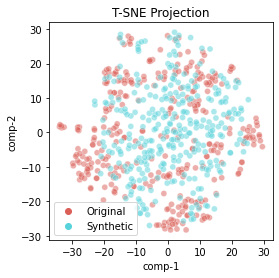

In [10]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2), alpha=0.5,
                data=df).set(title=f"T-SNE Projection")
plt.xlabel('comp-1')
plt.ylabel('comp-2')
plt.legend()

plt.show()

**Visualise adjacency matrix**

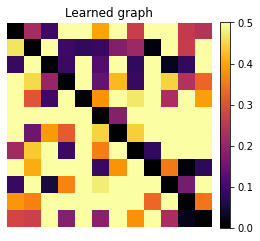

In [11]:
adj_matrix = gen.model.learned_graph(None).cpu().detach().numpy()
adj_matrix = np.abs(adj_matrix)
plt.figure(figsize=(4, 4))
im = plt.imshow(adj_matrix, cmap='inferno', interpolation='nearest', vmin=0, vmax=0.5)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Learned graph')
plt.axis('off')
plt.show()